In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.4.0
GPU is available


In [2]:
# %% === < Global Setting: Time and Seed > ===
import time
import numpy as np
local_time = time.strftime("%Y%m%d_%H%M", time.localtime())
print("Time:", local_time)
seed = int(round(1000000*np.random.random()))
print("Seed:", seed)
np.random.seed(seed)

Time: 20210609_1503
Seed: 981559


In [3]:
import os
output_folder = './Result/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

(512, 512, 3)
(512, 512)


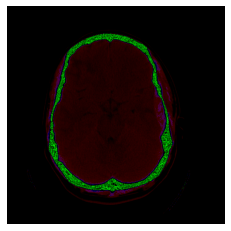

In [4]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('./Data/TrainDataWindow/epidural/ID_000edbf38.png')
img_shape = img.shape
img_size = img_shape[0:2]
print(img_shape)
print(img_size)
plt.figure()
plt.imshow(img)
plt.axis('off')
plt.show()

In [5]:
# %% === < Images importing > ===
import os
import tensorflow as tf
batch_size = 16
print('raw image size:',img_size)
print('raw image shape:',img_shape)

TrainDataFolder = 'Data/TrainDataWindow'
ValidDataFolder = 'Data/ValidDataWindow'
TestDataFolder = 'Data/TestDataWindow'
TrainDataGenerator = 'Data/TrainDataGenerator'
ValidDataGenerator = 'Data/ValidDataGenerator'
if not os.path.exists(TrainDataGenerator):
    os.makedirs(TrainDataGenerator)
if not os.path.exists(ValidDataGenerator):
    os.makedirs(ValidDataGenerator)

raw image size: (512, 512)
raw image shape: (512, 512, 3)


In [6]:
model_img_side = 299
image_size = (model_img_side,model_img_side)
image_shape = (model_img_side,model_img_side,3)
print('image size:',image_size)
print('image shape:',image_shape)

image size: (299, 299)
image shape: (299, 299, 3)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_kwargs = dict(rescale=1./255)

TrainDataGenerator = ImageDataGenerator(
    rotation_range=5,
    zoom_range=[0.9,1.0],
    width_shift_range=0.1,
    height_shift_range=0.1,
#     fill_mode='nearest',
    **datagen_kwargs
    )
ValidDataGenerator = ImageDataGenerator(
    rotation_range=5,
    zoom_range=[0.9,1.0],
    width_shift_range=0.1,
    height_shift_range=0.1,
#     fill_mode='nearest',
    **datagen_kwargs
    )
TestDataGenerator = ImageDataGenerator(
    **datagen_kwargs
    )

In [8]:
dataflow_kwargs = dict(target_size=image_size, batch_size=batch_size)

TrainingDataset = TrainDataGenerator.flow_from_directory(
    TrainDataFolder,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False,
    **dataflow_kwargs
    )
ValidationDataset = ValidDataGenerator.flow_from_directory(
    ValidDataFolder,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False,
    **dataflow_kwargs
    )
TestingDataset = TestDataGenerator.flow_from_directory(
    TestDataFolder,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False,
    **dataflow_kwargs
    )

Found 4200 images belonging to 6 classes.
Found 1800 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [9]:
print('Number of category: %d' % TrainingDataset.num_classes)

Number of category: 6


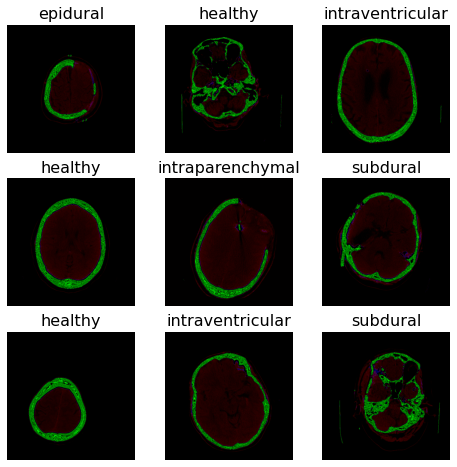

In [10]:
import matplotlib.pyplot as plt
import cv2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

files_path = TrainingDataset.filenames
demo_files_path = np.random.choice(files_path,9)

plt.figure(figsize=(8,8))
idx = 0
for file in demo_files_path:
    ax = plt.subplot(3, 3, idx + 1)
    img = cv2.imread(os.path.join(TrainDataFolder,file))
    category_name = os.path.split(file)
    plt.imshow(img)
    plt.title(category_name[0])
    plt.axis("off")
    idx = idx + 1
plt.savefig(output_folder+'Example_%s.png'%local_time, dpi=300, bbox_inches='tight')

In [11]:
# %% === < Importing pretrained model with custom input shape > ===
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
model_based = InceptionV3(weights='imagenet', include_top=True)
model_based.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
# model_based.layers.pop()
out = Dense(6, activation='softmax', name='output')(model_based.layers[-2].output)
model = Model(model_based.layers[0].output,out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
model.compile(
    optimizer = SGD(learning_rate = 0.001, momentum=0.99, nesterov=True), 
    loss = CategoricalCrossentropy(), 
    metrics = ['accuracy']
    )
initial_epochs = 10
loss0, accuracy0 = model.evaluate(ValidationDataset)
print("Initial loss: {:.2f}".format(loss0))
print("Initial accuracy: {:.2f}".format(accuracy0))

113/113 [==============================] - 12s 73ms/step - loss: 1.7927 - accuracy: 0.1536
Initial loss: 1.79
Initial accuracy: 0.18


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
steps_per_epoch = TrainingDataset.samples // TrainingDataset.batch_size
validation_steps = ValidationDataset.samples // ValidationDataset.batch_size
EarlyStop = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min', 
    patience = 5,
    verbose = 1
    )
LRSchedule = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience = 3, 
    verbose = 1
    )
history = model.fit(
    TrainingDataset,
    validation_data = ValidationDataset,
    epochs = initial_epochs,
#     steps_per_epoch=steps_per_epoch,
#     validation_steps=validation_steps,
    verbose = 1,
    callbacks = [EarlyStop, LRSchedule]
    )

Epoch 1/10
263/263 [==============================] - 81s 298ms/step - loss: 1.7860 - accuracy: 0.2074 - val_loss: 1.7749 - val_accuracy: 0.2261
Epoch 2/10
263/263 [==============================] - 78s 298ms/step - loss: 1.7645 - accuracy: 0.2279 - val_loss: 1.7546 - val_accuracy: 0.2450
Epoch 3/10
263/263 [==============================] - 78s 298ms/step - loss: 1.7537 - accuracy: 0.2343 - val_loss: 1.7453 - val_accuracy: 0.2200
Epoch 4/10
263/263 [==============================] - 78s 298ms/step - loss: 1.7364 - accuracy: 0.2579 - val_loss: 1.7276 - val_accuracy: 0.2628
Epoch 5/10
263/263 [==============================] - 78s 298ms/step - loss: 1.7213 - accuracy: 0.2581 - val_loss: 1.7233 - val_accuracy: 0.2572
Epoch 6/10
263/263 [==============================] - 78s 298ms/step - loss: 1.7153 - accuracy: 0.2698 - val_loss: 1.7132 - val_accuracy: 0.2472
Epoch 7/10
263/263 [==============================] - 78s 298ms/step - loss: 1.7056 - accuracy: 0.2771 - val_loss: 1.7129 - val_ac

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

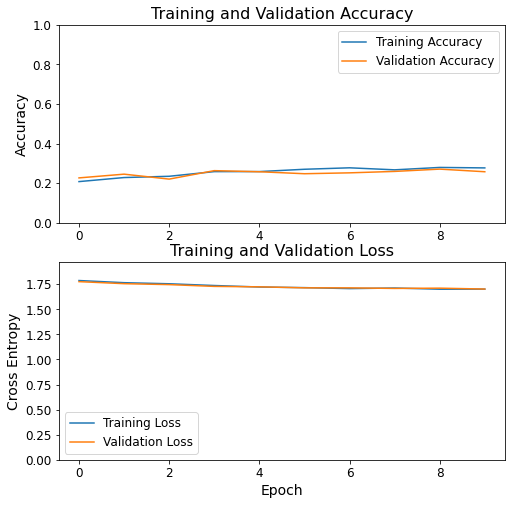

In [17]:
plt.figure(figsize=(8,8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0,1])
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,1.1*max(plt.ylim())])
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.title('Training and Validation Loss')

plt.savefig(output_folder+'History_BeforeTune_%s.png'%local_time, dpi=300, bbox_inches='tight')

In [18]:
model.trainable = True

In [19]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
model.compile(
    optimizer = SGD(learning_rate = 0.001, momentum=0.99, nesterov=True), 
    loss = CategoricalCrossentropy(), 
    metrics = ['accuracy']
    )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1000)              23851784  
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1025024   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 3078      
Total params: 25,404,686
Trainable params: 25,370,254
Non-trainable params: 34,432
_________________________________________________________________


In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
fine_tune_1_epochs = 190
total_1_epochs =  initial_epochs + fine_tune_1_epochs
EarlyStop = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min', 
    patience = 15,
    verbose = 1
    )
LRSchedule = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience = 5, 
    verbose = 1
    )
history_fine_1 = model.fit(TrainingDataset,
    validation_data=ValidationDataset,
    epochs=total_1_epochs,
    initial_epoch=history.epoch[-1],
    verbose = 1,
    callbacks = [EarlyStop, LRSchedule]
    )

Epoch 10/200
263/263 [==============================] - 86s 308ms/step - loss: 1.8330 - accuracy: 0.1811 - val_loss: 1.7761 - val_accuracy: 0.2517
Epoch 11/200
263/263 [==============================] - 80s 302ms/step - loss: 1.7088 - accuracy: 0.2910 - val_loss: 1.7087 - val_accuracy: 0.2756
Epoch 12/200
263/263 [==============================] - 79s 301ms/step - loss: 1.6213 - accuracy: 0.3220 - val_loss: 1.7153 - val_accuracy: 0.2811
Epoch 13/200
263/263 [==============================] - 79s 301ms/step - loss: 1.6078 - accuracy: 0.3123 - val_loss: 2.0386 - val_accuracy: 0.2589
Epoch 14/200
263/263 [==============================] - 80s 302ms/step - loss: 1.5678 - accuracy: 0.3153 - val_loss: 1.5287 - val_accuracy: 0.3294
Epoch 15/200
263/263 [==============================] - 76s 289ms/step - loss: 1.5172 - accuracy: 0.3217 - val_loss: 1.5073 - val_accuracy: 0.3600
Epoch 16/200
263/263 [==============================] - 75s 283ms/step - loss: 1.4443 - accuracy: 0.3817 - val_loss: 1

In [21]:
acc += history_fine_1.history['accuracy']
val_acc += history_fine_1.history['val_accuracy']

loss += history_fine_1.history['loss']
val_loss += history_fine_1.history['val_loss']

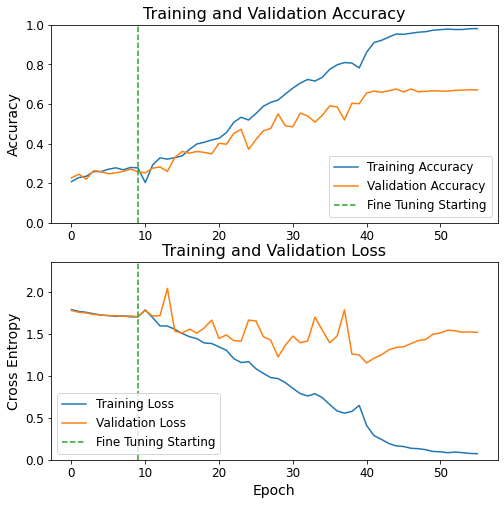

In [22]:
plt.figure(figsize=(8,8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim([0,1]),'--', label='Fine Tuning Starting')
plt.ylim([0,1])
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim([0,1.1*max(plt.ylim())]),'--', label='Fine Tuning Starting')
plt.ylim([0,max(plt.ylim())])
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.title('Training and Validation Loss')

plt.savefig(output_folder+'History_FineTuning_%s.png'%local_time, dpi=300, bbox_inches='tight')

In [23]:
# --- saving weights and structure
model_h5_folder = output_folder+'ModelWeights/'
model_h5_file = 'ResNet50_' + local_time + '.h5'
model.save(model_h5_folder + model_h5_file)  # creates a HDF5 file

In [24]:
list_loss = []
list_acc = []

loss, accuracy = model.evaluate(TrainingDataset)
list_loss.append(loss)
list_acc.append(accuracy)
print("Training loss: {:.4f}".format(loss))
print("Training accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(ValidationDataset)
list_loss.append(loss)
list_acc.append(accuracy)
print("Validation loss: {:.4f}".format(loss))
print("Validation accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(TestingDataset)
list_loss.append(loss)
list_acc.append(accuracy)
print("Testing loss: {:.4f}".format(loss))
print("Testing accuracy: {:.4f}".format(accuracy))

with open(output_folder+'loss_%s.txt'%local_time, 'w') as f:
    for item in list_loss:
        f.write("%s\n" % item)
with open(output_folder+'acc_%s.txt'%local_time, 'w') as f:
    for item in list_acc:
        f.write("%s\n" % item)

263/263 [==============================] - 68s 259ms/step - loss: 0.0488 - accuracy: 0.9902
Training loss: 0.0488
Training accuracy: 0.9902
113/113 [==============================] - 7s 60ms/step - loss: 1.5156 - accuracy: 0.6711
Validation loss: 1.5156
Validation accuracy: 0.6711
38/38 [==============================] - ETA: 0s - loss: 1.5119 - accuracy: 0.67 - 2s 59ms/step - loss: 1.5070 - accuracy: 0.6733
Testing loss: 1.5070
Testing accuracy: 0.6733


In [25]:
pred_prop_training = model.predict(TrainingDataset)
pred_prop_validation = model.predict(ValidationDataset)
pred_prop_testing = model.predict(TestingDataset)
print(pred_prop_testing)

pred_training = tf.argmax(pred_prop_training, axis=1)
pred_validation = tf.argmax(pred_prop_validation, axis=1)
pred_testing = tf.argmax(pred_prop_testing, axis=1)
print(pred_testing)

true_training = TrainingDataset.classes
true_validation = ValidationDataset.classes
true_testing = TestingDataset.classes
print(true_testing)

[[9.90211129e-01 1.16349293e-05 9.19269281e-04 1.33617932e-05
  5.80948486e-04 8.26365780e-03]
 [9.85425860e-02 5.04148146e-03 2.63173191e-04 5.80489577e-04
  4.54468466e-03 8.91027629e-01]
 [9.91474390e-01 9.07996764e-06 7.63665535e-04 1.07639880e-05
  4.58885421e-04 7.28317164e-03]
 ...
 [1.35432435e-02 5.93959466e-02 1.14998649e-04 1.55096652e-03
  4.86226380e-03 9.20532584e-01]
 [7.50818998e-02 3.20330798e-03 1.04462270e-04 3.86163360e-04
  1.57282990e-03 9.19651270e-01]
 [1.32720289e-03 9.40463901e-01 3.24330067e-05 9.01895575e-04
  8.15227721e-03 4.91223335e-02]]
tf.Tensor(
[0 5 0 5 1 0 0 4 0 0 5 0 0 0 0 5 0 0 5 4 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0
 2 0 0 5 0 0 0 0 0 0 5 0 5 5 0 5 0 0 0 5 3 4 0 0 2 0 0 0 1 0 0 0 5 5 0 0 0
 0 0 0 0 5 0 0 1 5 2 5 0 0 0 0 0 0 0 0 4 0 0 5 4 0 5 5 1 4 1 5 5 1 1 1 1 1
 1 5 1 1 1 1 1 1 1 5 2 1 5 1 1 1 1 5 1 1 1 1 1 1 5 1 1 1 5 1 0 4 5 0 1 1 1
 4 4 1 1 3 1 1 1 4 1 1 1 1 3 2 1 1 1 1 1 1 1 1 1 1 1 1 5 1 4 1 1 1 3 1 1 1
 1 1 5 5 4 5 1 1 2 1 4 1 1 3 1 1 0 2 2

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
def info(true,pred,type_data):
    # === Accuracy
    print("Accuracy: %.4f"%accuracy_score(true,pred))
    report = classification_report(true,pred,output_dict=True)
    df = pd.DataFrame(report).transpose()
    df.to_csv(output_folder+'ClassificationReport_%s_%s.csv'%(type_data,local_time), index = True)
    print(classification_report(true,pred))
    # === Confusion Matrix
    plt.figure()
    sns.heatmap(confusion_matrix(true,pred,normalize=None), annot=True, cmap='YlGnBu')
#     xticklabels=target_names, yticklabels=target_names
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.savefig(output_folder+'ConfusionMatrix_%s_%s.png'%(type_data,local_time), dpi=300, bbox_inches='tight')
    plt.show()
    # === Normalized Confusion Matrix
    plt.figure()
    sns.heatmap(confusion_matrix(true,pred,normalize='true'), annot=True, cmap='Blues', vmin=0, vmax=1)
#     xticklabel=starget_names, yticklabels=target_names
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix')
    plt.savefig(output_folder+'NormalizeConfusionMatrix_%s_%s.png'%(type_data,local_time), dpi=300, bbox_inches='tight')
    plt.show() 

Accuracy: 0.1710
              precision    recall  f1-score   support

           0       0.20      0.20      0.20       700
           1       0.16      0.16      0.16       700
           2       0.16      0.16      0.16       700
           3       0.16      0.16      0.16       700
           4       0.18      0.18      0.18       700
           5       0.17      0.17      0.17       700

    accuracy                           0.17      4200
   macro avg       0.17      0.17      0.17      4200
weighted avg       0.17      0.17      0.17      4200



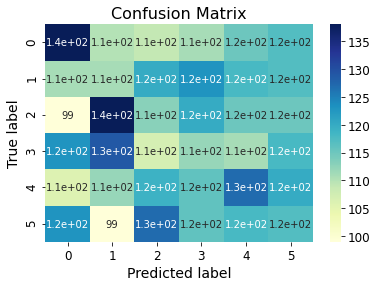

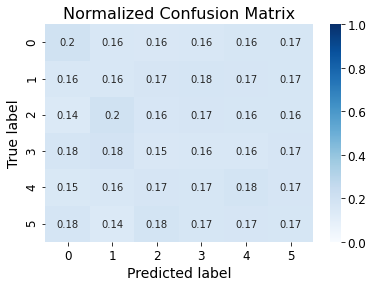

In [27]:
info(true_training,pred_training,'training')

Accuracy: 0.6711
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       300
           1       0.67      0.70      0.68       300
           2       0.63      0.71      0.67       300
           3       0.81      0.79      0.80       300
           4       0.58      0.55      0.56       300
           5       0.61      0.62      0.62       300

    accuracy                           0.67      1800
   macro avg       0.67      0.67      0.67      1800
weighted avg       0.67      0.67      0.67      1800



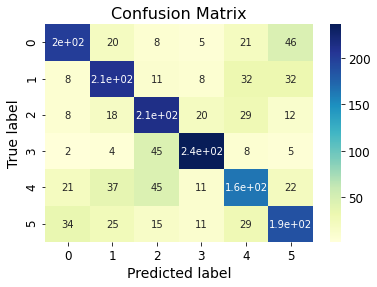

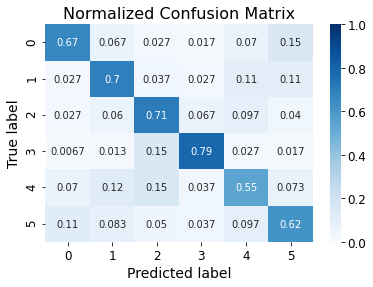

In [28]:
info(true_validation,pred_validation,'validation')

Accuracy: 0.6733
              precision    recall  f1-score   support

           0       0.73      0.68      0.70       100
           1       0.71      0.69      0.70       100
           2       0.64      0.77      0.70       100
           3       0.79      0.76      0.78       100
           4       0.67      0.54      0.60       100
           5       0.53      0.60      0.56       100

    accuracy                           0.67       600
   macro avg       0.68      0.67      0.67       600
weighted avg       0.68      0.67      0.67       600



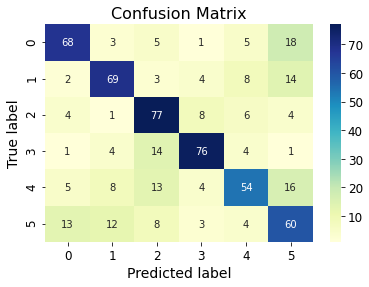

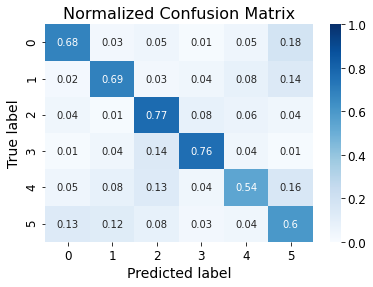

In [29]:
info(true_testing,pred_testing,'testing')

In [30]:
# %% === < Finish Time > ===
import time
print("Finish Time:", time.strftime("%Y%m%d_%H%M", time.localtime()))

Finish Time: 20210609_0419
